In [0]:
# Fill in your name using the format below and student ID number
your_name = "Merz, Gerrit"
student_id = "1553410"

In [0]:
# Before submission, set this to True so that you can render and verify this notebook without training deep learning models.
# Any deep learning models will be trained from file instead.
stop_training = True

In [0]:
# Uncomment the following line to run in Google Colab
!pip install --quiet openml 

In [0]:
# Uncomment the following line to run in Google Colab
%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

In [0]:
%matplotlib inline
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [0]:
from packaging import version
import sklearn
import tensorflow
sklearn_version = sklearn.__version__
tensorflow_version = tensorflow.__version__
if version.parse(sklearn_version) < version.parse("0.22.0"):
    print("scikit-learn is outdated. Please update now!")
if version.parse(tensorflow_version) < version.parse("2.1.0"):
    print("Tensorflow is outdated. This is version {}. Please update to 2.1.".format(tensorflow_version))
else:
    print("Hi{}, Looks good. You may continue :)".format(your_name.split(",")[1]))

Hi Gerrit, Looks good. You may continue :)


# Assignment 3

### Choice of libraries
We recommend to use Tensorflow in this assignment since that is what we covered in the labs. If you feel confident using PyTorch (and Skorch for the scikit-learn wrapper), that is allowed too, as long as you are able to implement the requested functions and return the requested data. Read the assignment carefully and ensure that you can. Note that you may also need to do a bit more work to implement certain helper functions and wrappers.

### Storing and submitting files
You must be able to store your models and submit them to GitHub Classroom. The evaluation functions used in this notebook will automatically store models for you.

If you want to run and solve the notebook on your local machine/laptop, fill in the path 'base_dir' to your assignment folder into the next cell.

If you use Colab, we recommend that you link it to your Google Drive:  
* Upload the assignment folder to your Google Drive (+ New > Folder Upload)
* Open Colab in a browser, open the 'Files' menu in the left sidebar, and click 'Mount Drive'
  * At this point you may need to authenticate
* Fill in the path to your assignment folder below
  * It's likely '/content/drive/My Drive/assignment-3-yourname'

In [0]:
base_dir = "/content/drive/My Drive/assignment-3-Gerdome" # For Google Colab

In [0]:
#Uncomment to link Colab notebook to Google Drive
from google.colab import drive
drive.mount('/content/drive')

### Using GPUs
While you can solve this assignment on a CPU, using a GPU will speed things up training quite a bit. If you have a local GPU, you can use that. If you don't, we recommend Google Colab. When you are in Colab:
* In Runtime > Change runtime type, select the GPU under Hardware Accelerator
* Run the 3rd cell on the top of this notebook to check that the GPU is found.

Note that Colab may not always have GPUs ready all the time, and may deny you a GPU when you have used them a lot. When you are temporarily 'locked out', you can switch to a non-GPU runtime or to a local instance of Jupyter running on your machine.

### Constraints
* Your stored models should not be larger than 100MB when stored in file. GitHub will not allow uploading if they are.
* When questions ask you to provide an explanation, it should be less than 500
characters long. Some questions have a higher limit. Always answer in full sentences.
* Don't train for more than 100 epochs, i.e. don't throw excessing computational resources at the problem. If your model hasn't converged by then, think of ways it could be made to converge faster. In this assignment you are not after the last tiny improvement, you can stop when learning curves flatten out. Do at least 5 epochs to get a reasonable learning curve.

### Grading
Grading is based on the following aspects:
* Correctness in answering the question. Carefully read the question and answer
what is asked for. Train your models on the correct data. It should be clear on which data should be trained, but ask when in doubt. When something is not defined (e.g. the number of epochs or batch size), you can freely choose them.
* Clarity of your explanations. Write short but precise descriptions of what you did and why. Give short but clear explanations of the observed performance. 
After your explanation, your approach and model should make perfect sense. Refrain from using symbols as substitute for words in your explanation (e.g. no: "More layers -> more parameters" yes: "More layers mean more parameters"). 
* Part of your grade depends on how well your model performs. When the question says 'you should at least get x%', x% will give you a good but not the maximal grade. You can get the full grade when you are close to what is the expected maximal performance. You don't need to invest lots of effort into the last tiny improvement, though. Unless specified, we look at the accuracy on the validation set. If your learning curves are very erratic we'll compute a score based on the smoothed curves (i.e. single peaks don't count).
* The weight of each question is indicated. Take this into account when planning your time.

### Other tips
* Don't wait until the last minute to do the assignment. The models take time to train, most questions will require some thinking, and some require you to read up on some new concepts.
* Take care that you upload the results as requested. You need to submit not only the notebooks but also the trained models and learning curves (training histories). Be sure to run the verification script and check that all the results are included.
* We provide an evaluation function that also stored models to disk. After you are done training the model, set the 'train' attribute to False so that the model doesn't train again (and loads from file instead) when you restart and rerun your notebook.
* Explore. For many questions we'll ask you to explain your model design decisions. You cannot magically know the best solutions but you can experiment
based on your understanding and make decisions based on both your knowledge and experiments. Your explanation is at least as important as the performance of your model.
* Be original. We will check for plagiarism between student submissions.

### Data
The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 1, '9' has label 9 and '0' has label 10. Your goal is to build models that recognize the correct digit.

If you use Colab, uncomment the following to cache the dataset inside the VM. This will make reloading faster if you need to restart your notebook. After longer periods of inactivity, your VM may be recycled and the cache lost, in which case the dataset will be downloaded again. Also note that this dataset is about 1Gb large, and will take even more space in memory. You may need to switch to a high-RAM environment (Colab will ask you if you hit the limit).

In [0]:
# Use OpenML caching in Colab
# On your local machine, it will store data in a hidden folder '~/.openml'
import os
oml.config.cache_directory = os.path.expanduser('/content/cache')

In [0]:
# Download Streetview data. Takes a while (several minutes), and quite a bit of
# memory when it needs to download. After caching it loads faster.
SVHN = oml.datasets.get_dataset(41081)
X, y, _, _ = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

In [0]:
from tensorflow.keras import models
from tensorflow.keras import layers 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import cv2
from tensorflow.keras.applications.vgg16 import VGG16
from random import randint
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Reshape, sample and split the data

In [0]:
# Explore the data
X.shape
# 3072 features: 32 by 32 and one for each color (R,G,B)

(99289, 3072)

In [0]:
Xr = X.reshape((len(X),32,32,3))
Xr = Xr / 255.
yr = to_categorical(y)
Xr.shape

(99289, 32, 32, 3)

In [0]:
# DO NOT EDIT. DO NOT OVERWRITE THESE VARIABLES.

# We do an 80-20 split for the training and test set, and then again a 80-20 split into training and validation data
X_train_all, X_test, y_train_all, y_test = train_test_split(Xr,yr, stratify=yr, train_size=0.8, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_all,y_train_all, stratify=y_train_all, train_size=0.8, random_state=1)
evaluation_split = X_train, X_val, y_train, y_val

Check the formatting - and what the data looks like

In [0]:
# Takes a list of row ids, and plots the corresponding images
# Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    for n in range(len(X)):
        if grayscale:
            axes[n].imshow(X[n], cmap='gray')
        else:
            axes[n].imshow(X[n])
        axes[n].set_xlabel((np.argmax(y[n])+1)%10) # Label is index+1
        axes[n].set_xticks(()), axes[n].set_yticks(())
    plt.show();

images = [randint(0,len(X_train)) for i in range(5)]
X_random = [X_train[i] for i in images]
y_random = [y_train[i] for i in images]
plot_images(X_random, y_random)

### Evaluation harness
We provide an evaluation function 'run_evaluation' that you should use to 
evaluate all your models. It also stores the trained models to disk so that
your submission can be quickly verified, as well as to avoid having to train
them over and over again. Your last run of the evaluation function (the last one
stored to file), is the one that will be evaluated. The 'train' argument indicates whether to train or to load from disk. We have provided helper functions for saving and loading models to/from file, assuming you use TensorFlow. If you use PyTorch you'll have to adapt them.

In [0]:
import os
import pickle
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model # for use with tensorflow

def shout(text, verbose=1):
    """ Prints text in red. Just for fun.
    """
    if verbose>0:
        print('\033[91m'+text+'\x1b[0m')

def load_model_from_file(base_dir, name, extension='.h5'):
    """ Loads a model from a file. The returned model must have a 'fit' and 'summary'
    function following the Keras API. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    base_dir -- Directory where the models are stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    try:
        model = load_model(os.path.join(base_dir, name+extension))
    except OSError:
        shout("Saved model could not be found. Was it trained and stored correctly? Is the base_dir correct?")
        return False
    return model

def save_model_to_file(model, base_dir, name, extension='.h5'):
    """ Saves a model to file. Don't change if you use TensorFlow. Otherwise,
    adapt as needed. 
    Keyword arguments:
    model -- the model to be saved
    base_dir -- Directory where the models should be stored
    name -- Name of the model, e.g. 'question_1_1'
    extension -- the file extension
    """
    model.save(os.path.join(base_dir, name+extension))

# Helper function to extract min/max from the learning curves
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

# DO NOT EDIT
def run_evaluation(name, model_builder, data, base_dir, train=True, 
                   generator=False, epochs=3, batch_size=32, steps_per_epoch=60, 
                   verbose=1, **kwargs):
    """ Trains and evaluates the given model on the predefined train and test splits,
    stores the trained model and learning curves. Also prints out a summary of the 
    model and plots the learning curves.
    Keyword arguments:
    name -- the name of the model to be stored, e.g. 'question_1_1.h5'
    model_builder -- function that returns an (untrained) model. The model must 
                     have a 'fit' function that follows the Keras API. It can wrap
                     a non-Keras model as long as the 'fit' function takes the 
                     same attributes and returns the learning curves (history).
                     It also must have a 'summary' function that prints out a 
                     model summary, and a 'save' function that saves the model 
                     to disk. 
    data -- data split for evaluation. A tuple of either:
            * Numpy arrays (X_train, X_val, y_train, y_val)
            * A data generator and validation data (generator, X_val, y_val)
    base_dir -- the directory to save or read models to/from
    train -- whether or not the data should be trained. If False, the trained model
             will be loaded from disk.
    generator -- whether the data in given as a generator or not
    epochs -- the number of epochs to train for
    batch_size -- the batch size to train with
    steps_per_epoch -- steps per epoch, in case a generator is used (ignored otherwise)
    verbose -- verbosity level, 0: silent, 1: minimal,...
    kwargs -- keyword arguments that should be passed to model_builder.
              Not required, but may help you to adjust its behavior
    """
    model = model_builder(**kwargs)
    if not model:
        shout("No model is returned by the model_builder")
        return
    if not hasattr(model, 'fit'):
        shout("Model is not built correctly")
        return
    learning_curves = {}
    if train and not stop_training: # Train anew
        shout("Training the model", verbose)
        if generator:
            generator, X_val, y_val = data
            history = model.fit(generator, epochs=epochs, batch_size=batch_size,
                              steps_per_epoch=steps_per_epoch, verbose=1, 
                              validation_data=(X_val, y_val))
            learning_curves = history.history
        else:
            X_train, X_val, y_train, y_val = data
            history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              verbose=1, validation_data=(X_val, y_val))
            learning_curves = history.history
        shout("Saving to file", verbose)
        save_model_to_file(model, base_dir, name)
        with open(os.path.join(base_dir, name+'.p'), 'wb') as file_pi:
            pickle.dump(learning_curves, file_pi)
        shout("Model stored in "+base_dir, verbose)
    else: # Load from file
        shout("Loading model from file", verbose)
        model = load_model_from_file(base_dir, name)
        if not model:
            shout("Model not found")
            return
        learning_curves = None
        try:
            learning_curves = pickle.load(open(os.path.join(base_dir, name+'.p'), "rb"))
        except FileNotFoundError:
            shout("Learning curves not found")
            return
        shout("Success!", verbose)
    # Report
    print(model.summary())
    lc = pd.DataFrame(learning_curves)
    lc.plot(lw=2,style=['b:','r:','b-','r-']);
    plt.xlabel('epochs');
    print(lc.apply(minMax))

## Part 1. Dense networks (10 points)

### Question 1.1: Baseline model (4 points)
- Build a dense network (with only dense layers) of at least 3 layers that is shaped like a pyramid: The first layer must have many nodes, and every subsequent layer must have increasingly fewer nodes, e.g. half as many. Implement a function 'build_model_1_1' that returns this model.
- You can explore different settings, but don't use any preprocessing or regularization yet. You should be able to achieve at least 70% accuracy, but more is of course better. Unless otherwise stated, you can use accuracy as the evaluation metric in all questions.
* Add a small description of your design choices (max. 500 characters) in 'answer_q_1_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- The name of the model should be 'model_1_1'. Evaluate it using the 'run_evaluation' function. For this question, you should not use more than 50 epochs.

Loading model from file
Success!
Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 3072)              0         
_________________________________________________________________
dense_72 (Dense)             (None, 128)               393344    
_________________________________________________________________
dense_73 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_74 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_75 (Dense)             (None, 10)                330       
Total params: 404,010
Trainable params: 404,010
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.943182  0.230848  0.

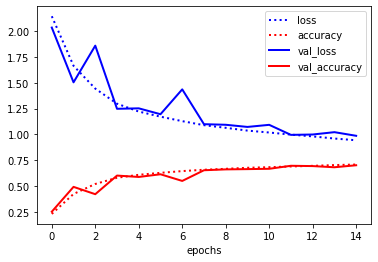

In [0]:
def build_model_1_1():
  model = models.Sequential()
  model.add(layers.Reshape((3072,), input_shape=(32,32,3)))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model
  
run_evaluation("model_1_1", build_model_1_1, evaluation_split, base_dir, 
              train=True, epochs=15, batch_size=64)
answer_q_1_1 = """
               Want to keep baseline model as a simple model, so I chose 4 dense layers (3 + output), starting with 128 nodes.
               Having more dense layers or more nodes resulted in less aligned curves between acc and val_acc (loss & val_loss).
               15 epochs is sufficient for now, as the learning curves already converge.
               Changing batch size to 64 results in more than 70% accuracy, but train and validation loss (and acc) not yet converging smoothly.
               """
print("Answer is {} characters long".format(len(answer_q_1_1)))

### Question 1.2: Preprocessing (2 points)
Rerun the model, but now preprocess the data first by converting the images to 
greyscale. You can use the helper function below. If you want to do additional 
preprocessing, you can do that here, too.
* Store the preprocessed data as a tuple `preprocessed_split`
* Rerun and re-evaluate your model using the preprocessed data.
  * For the remainder of the assignment, always use the preprocessed data
* Explain what you did and interpret the results in 'answer_q_1_2'. Is the model
  better, if so, why?

In [0]:
# Luminance-preserving RGB to greyscale conversion
def rgb2gray(X):
    return np.expand_dims(np.dot(X, [0.2990, 0.5870, 0.1140]), axis=3)

X_train_gr = rgb2gray(X_train)
X_val_gr = rgb2gray(X_val)
# Replace with the preprocessed data
preprocessed_split = X_train_gr, X_val_gr, y_train, y_val

Loading model from file
Success!
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_21 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_92 (Dense)             (None, 128)               131200    
_________________________________________________________________
dense_93 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_94 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_95 (Dense)             (None, 10)                330       
Total params: 141,866
Trainable params: 141,866
Non-trainable params: 0
_________________________________________________________________
None
         loss  accuracy  val_loss  val_accuracy
min  0.832885  0.277792  0.

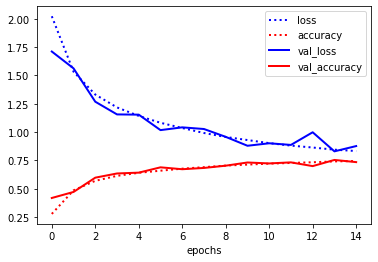

In [0]:
# Adjusted model
def build_model_1_2():
  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1))) 
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(32, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model

# Evaluate. Use a new name 'model_1_2' to not overwrite the previous trained model
run_evaluation("model_1_2", build_model_1_2, preprocessed_split, base_dir, 
               train=True, epochs=15, batch_size=64)
answer_q_1_2 = """
               I preprocessed the data by converting the X matrix (train and val) to greyscale, no need to change y.
               Using the exact same model as above with the greyscale input results in more than 74% acc (3% more than baseline model).
               Also, the acc learning curves are well aligned, indicating a well-fitted model. However, there are still slight deviations between the loss curves.
               """
print("Answer is {} characters long".format(len(answer_q_1_2)))

### Question 1.3: Regularization and tuning (4 points)
* Regularize the model. You can explore (and combine) different techniques. What works best?
* Tune other hyperparameters (e.g. learning rate, batch size,...) as you see fit.
* Explain your findings and final design decisions. Retrain the model again on the preprocessed data and discuss the results.
* Return your model in function 'build_model_1_3' and write your answer in 'answer_q_1_3'

Loading model from file
Success!
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_20 (Reshape)         (None, 1024)              0         
_________________________________________________________________
dense_102 (Dense)            (None, 1024)              1049600   
_________________________________________________________________
dense_103 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_104 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_105 (Dense)            (None, 256)               65792     
_________________________________________________________________
dense_106 (Dense)            (None, 128)               32896     
_________________________________________________________________
dense_107 (Dense)   

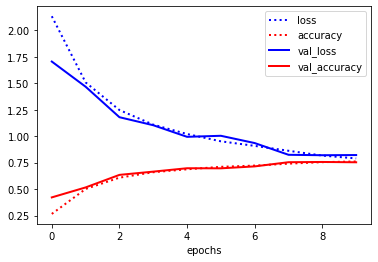

In [0]:
def build_model_1_3():

  model = models.Sequential()
  model.add(layers.Reshape((1024,), input_shape=(32,32,1))) 
  model.add(layers.Dense(1024, activation='relu'))
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(256,  activation='relu'))
  model.add(layers.Dense(256, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  return model
run_evaluation("model_1_3", build_model_1_3, preprocessed_split, base_dir, 
               train=True, epochs=10, batch_size=128)
answer_q_1_3 = """
               As the baseline model is well-fitted, I increase the complexity (one more dense layer and increasing nodes by factor 8) and achieve with adam optimizer higher accuracy (77%).
               Now, the curves converge earlier (less epochs needed). 
               Adding small l2-reg to the last two dense layers reduces the accuracy slightly (76%), but aligns the learning curves very well.
               Adding dropout layers leads to very bad scores, hence not used.
               """
print("Answer is {} characters long".format(len(answer_q_1_3)))

## Part 2. Convolutional neural networks (10 points)
### Question 2.1: Design a ConvNet (7 points)
- Build a sequential convolutional neural network. Try to achieve the best validation accuracy you can. You should be able to get at least 90% accuracy. You can use any depth, any combination of layers, and any kind of regularization and tuning. 
- Add a description of your design choices in 'answer_q_2_1': explain what you did and also why. Also discuss the performance of the model. Is it working well? Both the performance of the model and your explanations matter.
- You are allowed **800** characters for this answer (but don’t ramble).
- The name of the model should be 'model_2_1'. Evaluate it using the 'run_evaluation' function and the preprocessed data.

Training the model
Epoch 1/15
993/993 [==============================] - 23s 23ms/step - loss: 1.1205 - accuracy: 0.6556 - val_loss: 0.4495 - val_accuracy: 0.8702
Epoch 2/15
993/993 [==============================] - 23s 23ms/step - loss: 0.4424 - accuracy: 0.8683 - val_loss: 0.3126 - val_accuracy: 0.9039
Epoch 3/15
993/993 [==============================] - 23s 23ms/step - loss: 0.3637 - accuracy: 0.8920 - val_loss: 0.2928 - val_accuracy: 0.9099
Epoch 4/15
993/993 [==============================] - 23s 23ms/step - loss: 0.3266 - accuracy: 0.9038 - val_loss: 0.4402 - val_accuracy: 0.8621
Epoch 5/15
993/993 [==============================] - 23s 23ms/step - loss: 0.3047 - accuracy: 0.9116 - val_loss: 0.2397 - val_accuracy: 0.9281
Epoch 6/15
993/993 [==============================] - 23s 23ms/step - loss: 0.2870 - accuracy: 0.9169 - val_loss: 0.2520 - val_accuracy: 0.9265
Epoch 7/15
993/993 [==============================] - 23s 23ms/step - loss: 0.2745 - accuracy: 0.9204 - val_loss: 0.2

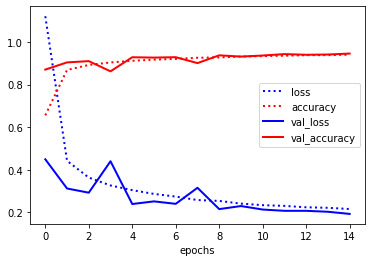

In [0]:
def build_model_2_1():
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 1)))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.3))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.4))
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
  model.add(layers.BatchNormalization())
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Dropout(0.5))
  model.add(layers.Flatten())
  model.add(layers.Dense(100, activation='relu'))
  model.add(layers.BatchNormalization())
  model.add(layers.Dropout(0.5))
  model.add(layers.Dense(10, activation='softmax'))
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

run_evaluation("model_2_1", build_model_2_1, preprocessed_split, base_dir, 
               train=True, epochs=15, batch_size=64)
answer_q_2_1 = """
               Baseline: conv net (1 conv layer) with a small filter size (3,3), a modest number of filters (32), followed by max pooling,
               results in a max acc of 91%. However, baseline model overfits as the val_loss curve converges at a higher number than the loss curve. 
               Using a VGG-like model (3 'blocks' of 2 convolutional layers each) results in higher max accuracy (96%), but overfits even stronger.
               Tackle overfitting: regularize deep layers more (increasing Dropout layers), downsampling (maxPooling layers) and stadardizing the outputs of convolutional and fully connected layers (BatchNormalization).
               Result: approx. 94% accuracy (strong score) and well regularized (loss and val_loss could be better aligned)
               """
print("Answer is {} characters long".format(len(answer_q_2_1)))

### Question 2.2: Data Augmentation (3 points)

- Augment the preprocessed training data. You can explore using image shifts, rotations, zooming, flips, etc. What works well, and what does not?
- Evaluate the model from question 2.1 with the augmented data using the 'run_evaluation' function. Store the new trained model as 'model_2_2'.
- Add a description of your design choices in 'answer_q_2_2': explain what you did and also why. Also discuss the performance of the model.

993
Loading model from file
Success!
Model: "sequential_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_7 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D

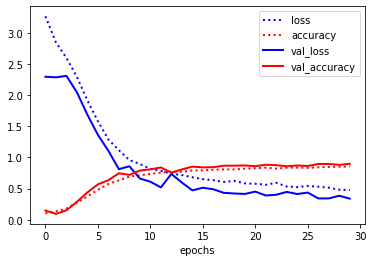

In [0]:
# Note that we build the same untrained model as in question 2.1 but store the 
# trained version as model_2_2. Change attributes as needed to run on augmented
# data

train_datagen = ImageDataGenerator(
    #rotation_range=30,
    zoom_range=0.1,
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    shear_range=0.1
    #horizontal_flip=True,
    #fill_mode="nearest"
)

it_train = train_datagen.flow(X_train_gr, y_train, batch_size=64)

print(len(it_train))

augmented_split = it_train, X_val_gr, y_val

run_evaluation("model_2_2", build_model_2_1, augmented_split, base_dir, 
              train=True, epochs=30, batch_size=None, generator = True)
answer_q_2_2 = """
               With augmentation, the curves need more epochs to converge, but resulting in lower accuracy(loss and val_loss also not better aligned).
               Augmentation seems to result in a loss of information, rather than helping to improve the performance. 
               Makes sense, because the level of information for digits images is low. Considering the large dataset and the quite well-fitted model above, the previosly trained model_2_1 will be used.
               """
print("Answer is {} characters long".format(len(answer_q_2_2)))

## Part 3. Model interpretation (10 points)
### Question 3.1: Interpreting misclassifications (2 points)
Study which errors are still made by your last model (model_2_2) by evaluating it on the test data. You do not need to retrain the model.
* What is the accuracy of model_2_2 on the test data? Store this in 'test_accuracy_3_1'.
* Plot the confusion matrix in 'plot_confusion_matrix' and discuss which classes are often confused.
* Visualize the misclassifications in more depth by focusing on a single
class (e.g. the number '2') and analyse which kinds of mistakes are made for that class. For instance, are the errors related to the background, noisiness, etc.? Implement the visualization in 'plot_misclassifications'.
* Summarize your findings in 'answer_q_3_1'

In [0]:
model_2_2 =  load_model_from_file(base_dir, 'model_2_1')
X_test_gr = rgb2gray(X_test)
y_pred = model_2_2.predict(X_test_gr)

acc = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
print(acc)

test_accuracy_3_1 = 0.9447577802397019

labels = {0: "1", 1: "2", 2: "3", 3: "4", 4: "5",5: "6", 6: "7", 7: "8", 8: "9", 9: "0"}

def plot_confusion_matrix():
  cm = confusion_matrix(np.argmax(y_test, axis=1),np.argmax(y_pred, axis=1))
  fig, ax = plt.subplots()
  im = ax.imshow(cm)
  ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
  ax.set_xticklabels(list(labels.values()), rotation=45, ha="right")
  ax.set_yticklabels(list(labels.values()))
  ax.set_ylabel('True')
  ax.set_xlabel('Predicted')
  for i in range(100):
      ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

def plot_misclassifications():
  digit = 8
  misclassified = np.nonzero((np.argmax(y_test, axis=1) != np.argmax(y_pred, axis=1)) & (np.argmax(y_test, axis=1) == (digit-1)))[0]
  rand = randint(0,len(misclassified))
  fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
  for nr, i in enumerate(misclassified[rand:rand+5]):
      axes[nr].imshow(X_test[i])
      axes[nr].set_xlabel("Predicted: %s,\n Actual : %s" % ((np.argmax(y_pred[i])+1)%10,(np.argmax(y_test[i])+1)%10)) 
      axes[nr].set_xticks(()), axes[nr].set_yticks(())
  plt.show()

answer_q_3_1 = """
               The following classes are confused most often: 1-7, 6-8, 3-5.
               Especially for 1-7 and 6-8, there are instances where not even the human eye could detect the differences.
               The following other reasons for missclassifications have been identified: 
               Some images have very bad quality, some images are rotated, some have an unusual design (either very curved or very edgy).
               Sometimes the image of the digit is cropped, so that the full digit is not visisble. Also, the "Center" of the image is sometimes in-between two digits.
               There are also cases, in which the digit is in the center but make up only very small part of the image. It also seems that some of the labels are wrong.
               
               """
print("Answer is {} characters long".format(len(answer_q_3_1)))

plot_confusion_matrix()
plot_misclassifications()

### Question 3.2: Visualizing activations (4 points)
* Implement a function `plot_activations()` that returns the most interesting activations (feature maps). Select the first example from the test set. Retrieve and visualize the activations of model 2_2 for that example (make sure you load that model in the function), for every filter for different convolutional layers (at different depths in the network).
* Give an explanation (as detailed as you can) about your observations in 'answer_q_3_2'. Is your model indeed learning something useful?

In [0]:
def plot_activations():
  img = X_test_gr[0]
  img = np.expand_dims(img, axis = 0)
  model_2_2 =  load_model_from_file(base_dir, 'model_2_1')

  layer_outputs = [layer.output for layer in model_2_2.layers]
  activation_model = models.Model(inputs=model_2_2.input, outputs=layer_outputs)

  activations = activation_model.predict(img)
  images_per_row = 16
  for layer_index in (0,2,6,8,12,14):
    layer_names = []
    for layer in model_2_2.layers:
      layer_names.append(layer.name)

    start = layer_index
    end = layer_index+1
    for layer_name, layer_activation in zip(layer_names[start:end], activations[start:end]):
        n_features = layer_activation.shape[-1]
        size = layer_activation.shape[1]
        n_cols = n_features // images_per_row
        display_grid = np.zeros((size * n_cols, images_per_row * size))
        for col in range(n_cols):
            for row in range(images_per_row):
                channel_image = layer_activation[0,
                                                  :, :,
                                                  col * images_per_row + row]
                channel_image -= channel_image.mean()
                channel_image /= channel_image.std()
                channel_image *= 64
                channel_image += 128
                channel_image = np.clip(channel_image, 0, 255).astype('uint8')
                display_grid[col * size : (col + 1) * size,
                              row * size : (row + 1) * size] = channel_image

        scale = 1. / size
        plt.figure(figsize=(scale * display_grid.shape[1],
                            scale * display_grid.shape[0]))
        plt.title("Activation of layer {} ({})".format(layer_index+1,layer_name))
        plt.grid(False)
        plt.imshow(display_grid, aspect='auto', cmap='viridis')

    plt.show()
  
answer_q_3_2 = """
               The activations of the filters in the first two conv layers retain almost all of the information present in the initial picture.
               The third conv layer activates increasingly abstract and less visually interpretable concepts. Conv Layer 4,5 and 6 carry increasingly less information about the visual contents of the image and more information related to the class of the image, for instance the inner circle of the 8, or the upper left corner of the 5.
               """
print("Answer is {} characters long".format(len(answer_q_3_2)))


Answer is 495 characters long


### Question 3.3: Visualizing activations (4 points)
* Again, select the first example from the test set, and the trained model_2_2.
* Implement a function `plot_activation_map()` that builds and shows a class activation map for your last convolutional layer that highlights what the model is paying attention to when classifying the example.
* If possible, superimpossible the activation map over the image. If not, plot
them side by side. Implement a function 'plot_3_3' that returns the entire plot.

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_108 (Conv2D)          (None, 32, 32, 32)        320       
_________________________________________________________________
batch_normalization_126 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_109 (Conv2D)          (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_127 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_110 (Conv2D)          (None, 16, 16, 64)      

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


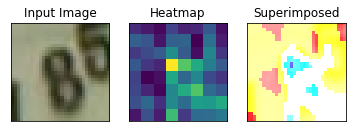

In [0]:
tf.compat.v1.disable_eager_execution()

def plot_3_3():
  img = X_test_gr[0]
  img = np.expand_dims(img, axis = 0)
  model_2_2 =  load_model_from_file(base_dir, 'model_2_1')
  last_conv_layer = model_2_2.get_layer('conv2d_113')
  eight_output = model_2_2.output[:, 7]
  grads = K.gradients(eight_output, last_conv_layer.output)[0]
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  iterate = K.function([model_2_2.input], [pooled_grads, last_conv_layer.output[0]])
  pooled_grads_value, conv_layer_output_value = iterate(img)

  for i in range(64):
      conv_layer_output_value[:, :, i] *= pooled_grads_value[i]
  img = X_test_gr[0]
  plt.subplot(131)
  plt.imshow(X_test[0])
  plt.title('Input Image')
  plt.xticks([])
  plt.yticks([])
  plt.plot()

  heatmap = np.mean(conv_layer_output_value, axis=-1)
  heatmap = np.maximum(heatmap, 0)
  heatmap /= np.max(heatmap)

  plt.subplot(132)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(heatmap)
  plt.title('Heatmap')

  heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

  superimposed_img = heatmap + img
  plt.subplot(133)
  plt.rcParams['figure.dpi'] = 120
  plt.imshow(superimposed_img)
  plt.title('Superimposed')
  plt.xticks([])
  plt.yticks([])
  plt.plot()

  plt.show()


## Part 4. Transfer learning (10 points)
### Question 4.1 Fast feature extraction with VGG16 (5 points)
- Import the VGG16 model, pretrained on ImageNet. [See here](https://keras.io/applications/). Only import the convolutional part, not the dense layers.
- Implement a function 'build_model_4_1` that adds a dense layer to the convolutional base, and freezes the convolutional base. Consider unfreezing the last few convolutional layers and evaluate whether that works better.
- Train the resulting model on the *original* (colored) training data
- Evaluate the resulting model using 'run_evaluate'. Discuss the observed performance in 'answer_q_4_1'.

Training the model
Epoch 1/10
993/993 [==============================] - 45s 46ms/step - loss: 1.2591 - accuracy: 0.5761 - val_loss: 0.8701 - val_accuracy: 0.7034
Epoch 2/10
993/993 [==============================] - 45s 45ms/step - loss: 0.8473 - accuracy: 0.7269 - val_loss: 0.8322 - val_accuracy: 0.7222
Epoch 3/10
993/993 [==============================] - 44s 45ms/step - loss: 0.7508 - accuracy: 0.7624 - val_loss: 0.6902 - val_accuracy: 0.7796
Epoch 4/10
993/993 [==============================] - 44s 45ms/step - loss: 0.6931 - accuracy: 0.7846 - val_loss: 0.8018 - val_accuracy: 0.7541
Epoch 5/10
993/993 [==============================] - 44s 45ms/step - loss: 0.6591 - accuracy: 0.7971 - val_loss: 0.7631 - val_accuracy: 0.7845
Epoch 6/10
993/993 [==============================] - 44s 45ms/step - loss: 0.6279 - accuracy: 0.8072 - val_loss: 0.7531 - val_accuracy: 0.7799
Epoch 7/10
993/993 [==============================] - 44s 45ms/step - loss: 0.6037 - accuracy: 0.8172 - val_loss: 0.7

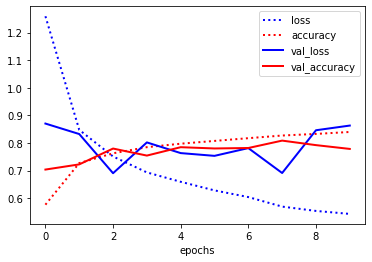

In [0]:
def build_model_4_1():
  #Get back the convolutional part of a VGG network trained on ImageNet
  vgg = VGG16(weights='imagenet', include_top=False, input_shape=(32,32,3))
  model = models.Sequential()
  model.add(vgg)
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  model.add(layers.Dense(10, activation='softmax'))

  #unfreeze last three convolutional layers
  for layer in vgg.layers:
      if layer.name in ('block5_conv1','block5_conv2','block5_conv3'):
          layer.trainable = True
      else:
          layer.trainable = False
  
  model.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  
  return model

run_evaluation("model_4_1", build_model_4_1, evaluation_split, base_dir, 
               train=True, epochs=10, batch_size=64)
answer_q_4_1 = """
               Freezing the conv base and training only the added layers results in very bad scores (less than 70%). Unfreezing the deepest convolutional block achieves better scores (80%), 
               but leads to overfitting when training on multiple epochs. Overall the performance of the meta-model is worse because the accuracy is worse and the model is overfitting.
               """
print("Answer is {} characters long".format(len(answer_q_4_1)))

### Question 4.2 Embeddings and pipelines (5 points)
- Generate embeddings of the original images by running them through the trained convolutional part of model_4_1 (without the dense layer) and returning the output. Embed the training and test data and store them to disk using the helper functions below. Implement a function `store_embeddings` that loads model_4_1 and stores all necessary embeddings to file. Make sure to run it once so that the embeddings are stored (and submitted).
- Implement a function 'generate_pipeline' that returns an scikit-learn pipeline. You can use any non-deep learning technique (eg. SVMs, RFs,...), and preprocessing technique. You can do model selection using the validation set. 
- Implement a function 'evaluate_pipeline' that evaluates a given pipeline on a given training and test set. 
- Implement a function 'evaluation_4_2' that evaluates your pipeline on the embedded training and test set (loaded from file) and returns the accuracy. 
- Describe what you did and what you observed. Report the obtained accuracy score. Can you beat your best model thus far?

In [0]:
import pickle
import gzip
from sklearn.preprocessing import StandardScaler, OneHotEncoder, Normalizer, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score, cross_validate

def store_embedding(X, name):
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'wb') as file_pi:
    pickle.dump(X, file_pi)

def load_embedding(name):
  with gzip.open(os.path.join(base_dir, name+'_embedding.p'), 'rb') as file_pi:
    return pickle.load(file_pi)

def store_embeddings():
  model_4_1 = load_model_from_file(base_dir, 'model_4_1')
  vgg = model_4_1.layers[-4]
  embedding_X_train = vgg.predict(X_train_all).reshape(79431,512)
  embedding_X_test = vgg.predict(X_test).reshape(19858,512)
  embeddings_train = np.concatenate((embedding_X_train, np.argmax(y_train_all, axis=1).reshape(79431,1)), axis=1)
  embeddings_test = np.concatenate((embedding_X_test, np.argmax(y_test, axis=1).reshape(19858,1)), axis=1)
  store_embedding(embeddings_train, 'train')
  store_embedding(embeddings_test, 'test')

def generate_pipeline():

  pipeline = Pipeline([
      ('scaler',StandardScaler()),
      ('clf', RandomForestClassifier(random_state=1))
  ])
    
  return pipeline

def evaluate_pipeline(pipeline, X_train, y_train, X_test, y_test):
  pipeline.fit(X_train,y_train)
  return pipeline.score(X_test, y_test)

def evaluation_4_2(X_train, y_train, X_test, y_test):

  #inserting here embedded sets due to error in verify
  embedding_X_train = load_embedding('train')[:,:-1]
  train_y = load_embedding('train')[:,-1]
  embedding_X_test = load_embedding('test')[:,:-1]
  test_y = load_embedding('test')[:,-1]

  score = evaluate_pipeline(generate_pipeline(), embedding_X_train, train_y, embedding_X_test, test_y)
  return score

answer_q_4_2 = """
               I generate the outputs for the train and test dataset seperately and reshape them into two dimensions, then concatenating with the corresponding labels and storing the two embeddings (train and test). The three functions (generate_, and two evaluate_) are nested and take the stored embeddings, feed them into the pipeline and evaluate the accuracy. For the pipeline, I choose RF as it scores good results and the model runs faster. I obtain an accuracy of 0.82%.
               """
print("Pipeline:",generate_pipeline())
print("Answer is {} characters long".format(len(answer_q_4_2)))

#store_embeddings()
#evaluation_4_2(load_embedding('train')[:,:-1], load_embedding('train')[:,-1], load_embedding('test')[:,:-1], load_embedding('test')[:,-1])

Pipeline: Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('clf',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=1, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=100, n_jobs=None,
                                        oob_score=False, random_state=1,
                                        verbose=0, warm_start=False))],
         verbose=False)
Answer is 495 

In [0]:
#%cd /content/drive/My\ Drive/assignment-3-Gerdome
#!python ./verify.py